In [1]:
import numpy as np
from scipy import *
import matplotlib.pyplot as plt
import time
import random
import math
import pandas as pd
import matplotlib
import itertools

# Function Defining Section

In [2]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [3]:
def InitiateShops(Num,Price_limit,Quality_Range,Capital,CostAtQuality):
    quality = [random.randint(*Quality_Range) for x in range(Num)]
    price = [random.randint(CostAtQuality[x],Price_limit) for x in quality]
    revenue = [0 for x in range(Num)]
    capital = [Capital for x in range(Num)]
    profit = [revenue[x]-capital[x] for x in range(Num)]
    products = [math.floor(capital[i]/CostAtQuality[x]) for i,x in enumerate(quality)]
    return [products,price,quality,revenue,capital,profit]
 
def InitiateUnifiedShops(Num,Price_Range,Quality_Range,Capital,CostAtQuality): #จะมีปรับปรุง
    price = [Price_Range[0] + math.ceil((x/Num)*(Price_Range[1]-Price_Range[0])) for x in range(Num)]
    quality = [Quality_Range[0] + math.ceil((x/Num)*(Quality_Range[1]-Quality_Range[0])) for x in range(Num)]
    revenue = [0 for x in range(Num)]
    capital = [Capital for x in range(Num)]
    products = [math.floor(capital[i]/CostAtQuality[x]) for i,x in enumerate(quality)]
    profit = [revenue[x]-capital[x] for x in range(Num)]
    return [products,price,quality,revenue,capital,profit]

def InitiateFocusedShop(Shop_List_input,price,quality,capital,CostAtQuality):
    Shop_List = [list(x) for x in Shop_List_input]
    Shop_List[0].append(math.floor(capital/CostAtQuality[quality]))
    Shop_List[1].append(price)
    Shop_List[2].append(quality)
    Shop_List[3].append(0)
    Shop_List[4].append(capital)
    Shop_List[5].append(0-capital)
    return Shop_List

def ExperimentShop(Shop_List_input,price,quality,capital,CostAtQuality):
    Shop_List = [list(x) for x in Shop_List_input]
    Shop_List[0].insert(0,math.floor(capital/CostAtQuality[quality]))
    Shop_List[1].insert(0,price)
    Shop_List[2].insert(0,quality)
    Shop_List[3].insert(0,0)
    Shop_List[4].insert(0,capital)
    Shop_List[5].insert(0,0-capital)
    return Shop_List

def AgentMaker(price,quality,capital,CostAtQuality):
    Output = []
    Output.append(math.floor(capital/CostAtQuality[quality]))
    Output.append(price)
    Output.append(quality)
    Output.append(0)
    Output.append(capital)
    Output.append(0-capital)
    return Output
    
def InitiateCustomer(Num,Wants_Range,Price_Range,Quality_Range,a_range = [0,1] ): #a*price + b*quality = Compatibility point
    product_wanted = [random.randint(*Wants_Range) for x in range(Num)]
    price_wanted = [random.randint(*Price_Range)*product_wanted[x] for x in range(Num)]
    quality_wanted = [random.randint(*Quality_Range) for x in range(Num)]
    ab = []
    for x in range(Num):    
        a = random.uniform(*a_range)
        b = 1-a
        AnB = [a,b]
        ab.append(AnB)
    return [product_wanted,price_wanted,quality_wanted,ab]

def FindShop(Index,Shop_List,Customer_List):
    product_wanted = Customer_List[0][Index]
    price_wanted = Customer_List[1][Index]
    quality_wanted = Customer_List[2][Index]
    a = Customer_List[3][Index][0]
    b = Customer_List[3][Index][1]
    all_price = [price for price in Shop_List[1]]
    Mean_Price = np.sum(all_price)/len(all_price)
    all_Ql = [ql for ql in Shop_List[2]]
    Mean_Ql = np.sum(all_Ql)/len(all_Ql)
    Selected = []
    for index,price in enumerate(Shop_List[1]):
        if price_wanted >= price*product_wanted:
            if Shop_List[0][index] >= product_wanted:
                Selected.append(index)
            else:
                continue
        else:
            continue
    if len(Selected) == 0:
        return None
    Compat_price = [(math.log(sigmoid((Shop_List[1][z]-Mean_Price)/Mean_Price),a)\
                     +math.log((-1)*sigmoid((Shop_List[2][z]-Mean_Ql)/Mean_Ql)+1,b)) for z in Selected]
    fake_index = Compat_price.index(max(Compat_price))
    Shop_to_buy_index = Selected[fake_index]
    
    return Shop_to_buy_index 

def Buying(Customer_Index,Shop_Index,Shop_List,Customer_List):
    product_wanted = Customer_List[0][Customer_Index]
    price_wanted = Customer_List[1][Customer_Index]
    quality_wanted = Customer_List[2][Customer_Index]
    Shop_List[0][Shop_Index] = Shop_List[0][Shop_Index] - product_wanted
    Shop_List[3][Shop_Index] = Shop_List[3][Shop_Index] + product_wanted * Shop_List[1][Shop_Index]
    Shop_List[5][Shop_Index] = Shop_List[5][Shop_Index] + product_wanted * Shop_List[1][Shop_Index]
    
def Simulate(Shop_List,Customer_List):
    for Customer_Index in range(len(Customer_List[0])):
        Shop_to_buy_index = FindShop(Customer_Index,Shop_List,Customer_List)
        if Shop_to_buy_index is None :
            continue
        Buying(Customer_Index,Shop_to_buy_index,Shop_List,Customer_List)

def Select(Pt_List,n):
    numbers = np.array(Pt_List)
    idx = np.argpartition(numbers, -n)[-n:]
    indices = idx[np.argsort((-numbers)[idx])]
    return indices

All Direction Method

In [4]:
def Breed(Shop,Pricelr,Qualitylr,capital,CostAtQuality,Momentum,price_limit,Ql_Range,Mutation_Rate = 1,mutate = True): #[products,price,quality,revenue,capital,profit]
    output = []
    quality = Shop[2] 
    price = Shop[1]
    if math.ceil(quality+Qualitylr) < len(CostAtQuality):
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality+Qualitylr)])
                      ,price+Pricelr
                      ,math.ceil(quality+Qualitylr)
                      ,0
                      ,capital
                      ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality+Qualitylr)])
                   ,price-Pricelr
                   ,math.ceil(quality+Qualitylr)
                   ,0
                   ,capital
                   ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality+Qualitylr)])
                      ,price
                      ,math.ceil(quality+Qualitylr)
                      ,0
                      ,capital
                      ,0-capital])
    if math.ceil(quality-Qualitylr) >= 0:
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality-Qualitylr)])
                      ,price-Pricelr
                      ,math.ceil(quality-Qualitylr)
                      ,0
                      ,capital
                      ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality-Qualitylr)])
                      ,price+Pricelr
                      ,math.ceil(quality-Qualitylr)
                      ,0
                      ,capital
                      ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality-Qualitylr)])
                  ,price
                  ,math.ceil(quality-Qualitylr)
                  ,0
                  ,capital
                  ,0-capital])
    output.append([math.floor(capital/CostAtQuality[math.ceil(quality)])
                   ,price+Pricelr
                   ,math.ceil(quality)
                   ,0
                   ,capital
                   ,0-capital])
    output.append([math.floor(capital/CostAtQuality[math.ceil(quality)])
                   ,price-Pricelr
                   ,math.ceil(quality)
                   ,0
                   ,capital
                   ,0-capital])

    ########
    if math.ceil(quality+Qualitylr*Momentum) < len(CostAtQuality):
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality+Qualitylr*Momentum)])
                      ,price+Pricelr*Momentum
                      ,math.ceil(quality+Qualitylr*Momentum)
                      ,0
                      ,capital
                      ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality+Qualitylr*Momentum)])
                ,price-Pricelr*Momentum
                ,math.ceil(quality+Qualitylr*Momentum)
                ,0
                ,capital
                ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality+Qualitylr*Momentum)])
                   ,price
                   ,math.ceil(quality+Qualitylr*Momentum)
                   ,0
                   ,capital
                   ,0-capital])
    if math.ceil(quality+Qualitylr*Momentum) >= 0:
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality-Qualitylr*Momentum)])
                      ,price-Pricelr*Momentum
                      ,math.ceil(quality-Qualitylr*Momentum)
                      ,0
                      ,capital
                      ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality-Qualitylr*Momentum)])
                      ,price+Pricelr*Momentum
                      ,math.ceil(quality-Qualitylr*Momentum)
                      ,0
                      ,capital
                      ,0-capital])
        output.append([math.floor(capital/CostAtQuality[math.ceil(quality-Qualitylr*Momentum)])
                          ,price
                          ,math.ceil(quality-Qualitylr*Momentum)
                          ,0
                          ,capital
                          ,0-capital])
    output.append([math.floor(capital/CostAtQuality[math.ceil(quality)])
                   ,price+Pricelr*Momentum
                   ,math.ceil(quality)
                   ,0
                   ,capital
                   ,0-capital])
    output.append([math.floor(capital/CostAtQuality[math.ceil(quality)])
                   ,price-Pricelr*Momentum
                   ,math.ceil(quality)
                   ,0
                   ,capital
                   ,0-capital])
    output.append([math.floor(capital/CostAtQuality[math.ceil(quality)])
                   ,price
                   ,math.ceil(quality)
                   ,0
                   ,capital
                   ,0-capital])
    if mutate:
        for x in range(Mutation_Rate):
            output.append([math.floor(capital/CostAtQuality[math.ceil(random.randint(*Ql_Range))])
                        ,random.randint(CostAtQuality[math.ceil(random.randint(*Ql_Range))],price_limit)
                        ,random.randint(*Ql_Range)
                        ,0
                        ,capital
                        ,0-capital])
    return output

Cells Method

In [5]:
class Optimization:
  def __init__(self,distribution_num,parameter_num,param_limit,param_lr):
    self.n = distribution_num
    self.np = parameter_num
    self.lim = param_limit #2d list [[,],[,]]
    self.param_lr = param_lr

  def Initiate(self):
    param_init = []
    for i,limit in enumerate(self.lim):
      a = []
      b = (limit[1]-limit[0])/((self.n[i]-2)+1)
      for i in range(self.n[i]):
          a.append(limit[0]+(i*b))
      param_init.append(a)
    p = itertools.product(*param_init)
    output = [list(i) for i in p]
    return output

  def Breed(self,init_coor,lr_indices):
    lr = self.param_lr
    list_a = []
    for coor in init_coor:
      list_b = []  
      for i,point in enumerate(coor):
        list_c = []
        if point+lr[i][lr_indices] <= self.lim[i][1]:
          list_c.append(point+lr[i][lr_indices])
        list_c.append(point+0)
        if point-lr[i][lr_indices] >= self.lim[i][0]:
          list_c.append(point-lr[i][lr_indices])
        list_b.append(list_c)
      list_a.append(list_b)
    output = []
    for cell in list_a:
      p = itertools.product(*cell)
      result = [list(i) for i in p]
      output.append(result)
    
    return output


GA Method

adapted from https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6 

In [6]:
import numpy

# This project is extended and a library called PyGAD is released to build the genetic algorithm.
# PyGAD documentation: https://pygad.readthedocs.io
# Install PyGAD: pip install pygad
# PyGAD source code at GitHub: https://github.com/ahmedfgad/GeneticAlgorithmPython

def cal_pop_fitness(equation_inputs, pop):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function caulcuates the sum of products between each input and its corresponding weight.
    fitness = numpy.sum(pop*equation_inputs, axis=1)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = numpy.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        random_index = random.randint(0,1)
        offspring_crossover[idx, random_index] = offspring_crossover[idx, random_index] + random_value
    return offspring_crossover

# Environment Defining Section

In [ ]:
#การกำหนดการสุ่มของร้านค้าคู่แข่ง 

random.seed(1000)       #อยากได้การสุ่มของสภาพแวดล้อมเดิมเดิมก็ใช้ Seed เดิม 

Capital_THEM = 4000     #ต้นทุนร้านอื่น
CostAtQuality = [math.ceil((x+1)*5+x**1.65) for x in range(10+1)] #ต้นทุนของคุณภาพแต่ละแบบ
price_limit = 100      #ราคาสูงสุดที่จะสุ่มได้ในร้านค้าคู่แข่ง
Ql_range = [0,10]       #ระดับคุณภาพของสินค้าที่จะถูกสุ่มของคู่แข่ง
Shop_Number = 10        #จำนวนร้านค้าคู่แข่ง
#Shop_List = InitiateShops(Shop_Number,price_limit,Ql_range,Capital_THEM,CostAtQuality) 
Shop_List = InitiateUnifiedShops(Shop_Number,[125,price_limit],Ql_range,Capital_THEM,CostAtQuality) 

#พารามีเตอร์ของร้านค้า [products,price,quality,revenue,capital,profit]

#การกำหนดการสุ่มของลูกค้า
random.seed(1000)        #อยากได้การสุ่มของสภาพแวดล้อมเดิมเดิมก็ใช้ Seed เดิม (ถ้าเราไม่เปลี่ยนอย่างอื่นเลยอ่ะนะ)
Customer_Num = 25        #จำนวนของลูกค้า
Want_Range = [1,4]       #ช่วงของการสุ่มจำนวนสินค้าที่อยากซื้อ
Budget_Range = [260,300] #ช่วงของงบ(ราคาสูงสุดที่จะซื้อได้)
Quality_Range = [1,10]   #ช่วงของคุณภาพสินค้าที่จะซื้อ(ไม่ได้ใช้แล้ว)
a_rand_range = [0,1]     #a_range คือค่า a ที่จะสุ่มได้ เอาไว้ปรับพฤติกรรมโดยรวมของลูกค้า
Customer_List = InitiateCustomer(Customer_Num,Want_Range,Budget_Range,Quality_Range,a_range = a_rand_range)

#พารามีเตอร์ของลูกค้า คือ [product_wanted,price_wanted,quality_wanted,ab]

Capital = 4000

In [ ]:
print("Customer Dataframe")
customer_array = np.concatenate((np.array(Customer_List[:-2]),np.array([list(np.array(Customer_List[-1]).T)[0]]),np.array([list(np.array(Customer_List[-1]).T)[1]])))
cutomer_df = pd.DataFrame(customer_array.T,columns = ['Products Wanted','Budget','A (price)','B (quality)'])
print(cutomer_df.round({'A (price)': 3, 'B (quality)': 3}))
print("A_average , B_average = ", np.mean(np.array(Customer_List[-1]).T[0]),",",np.mean(np.array(Customer_List[-1]).T[1]))
print("A_stdev , B_stdev = ", np.std(np.array(Customer_List[-1]).T[0]),",",np.std(np.array(Customer_List[-1]).T[1]))
print("A_coefv , B_coefv = ", np.std(np.array(Customer_List[-1]).T[0])/np.mean(np.array(Customer_List[-1]).T[0]),",",np.std(np.array(Customer_List[-1]).T[1]/np.mean(np.array(Customer_List[-1]).T[1])))

Customer Dataframe
    Products Wanted  Budget  A (price)  B (quality)
0               4.0  1176.0      0.633        0.367
1               1.0   289.0      0.504        0.496
2               4.0  1092.0      0.331        0.669
3               3.0   882.0      0.347        0.653
4               1.0   271.0      0.292        0.708
5               4.0  1064.0      0.765        0.235
6               2.0   552.0      0.478        0.522
7               4.0  1080.0      0.202        0.798
8               2.0   556.0      0.872        0.128
9               2.0   530.0      0.755        0.245
10              2.0   520.0      0.868        0.132
11              3.0   840.0      0.932        0.068
12              4.0  1044.0      0.242        0.758
13              2.0   600.0      0.892        0.108
14              3.0   828.0      0.766        0.234
15              2.0   556.0      0.415        0.585
16              4.0  1172.0      0.324        0.676
17              2.0   590.0      0.561       

In [ ]:
#การเซฟสภาพแวดล้อมของร้านค้าคู่แข่ง
np.save("Shop_Env.npy", np.array(Shop_List))
np.save("Customer_Env.npy", np.array(Customer_List))

cutomer_df.to_excel("Customer_Data.xlsx")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


# Brute Force and Objective Function Estimation

In [ ]:
brute_price_limit = Budget_Range[1]
price_step = 0.1
brute_quality_limit = 10
quality_step = 1

In [ ]:
brute_price_list  = []
brute_quality_list = []
price = 0
quality = 0
while True:
    brute_price_list.append(round(price,1))
    price += price_step 
    if price>brute_price_limit:
        break
while True:
    brute_quality_list.append(quality)
    quality += quality_step 
    if quality>brute_quality_limit:
        break

In [ ]:
p = itertools.product(brute_price_list,brute_quality_list)
brute_PQL_list = [list(i) for i in p]
len(brute_PQL_list)

33011

In [ ]:
brute_Profit_result = []
start = time.time()
for index,parameter in enumerate(brute_PQL_list):
    
    price = parameter[0]
    quality = round(parameter[1])
    Shop_List_Inloop = list(InitiateFocusedShop(Shop_List,price,quality,Capital,CostAtQuality))

    Simulate(Shop_List_Inloop,Customer_List)

    brute_Profit_result.append(Shop_List_Inloop[5][-1])

    if index % 1000 == 0:
        print(f"Index {index} Finished")

end = time.time()
print(f"Finished with {end-start} seconds taken")

Index 0 Finished
Index 1000 Finished
Index 2000 Finished
Index 3000 Finished
Index 4000 Finished
Index 5000 Finished
Index 6000 Finished
Index 7000 Finished
Index 8000 Finished
Index 9000 Finished
Index 10000 Finished
Index 11000 Finished
Index 12000 Finished
Index 13000 Finished
Index 14000 Finished
Index 15000 Finished
Index 16000 Finished
Index 17000 Finished
Index 18000 Finished
Index 19000 Finished
Index 20000 Finished
Index 21000 Finished
Index 22000 Finished
Index 23000 Finished
Index 24000 Finished
Index 25000 Finished
Index 26000 Finished
Index 27000 Finished
Index 28000 Finished
Index 29000 Finished
Index 30000 Finished
Index 31000 Finished
Index 32000 Finished
Index 33000 Finished
Finished with 37.12484622001648 seconds taken


In [ ]:
max_value = max(brute_Profit_result)
max_index = brute_Profit_result.index(max_value)
print(f"Max profit is {max_value} with price = {brute_PQL_list[max_index][0]} and quality = {brute_PQL_list[max_index][1]}")

Max profit is 1022.0 with price = 139.5 and quality = 10


In [ ]:
xyz_point = [x for x in brute_PQL_list]

for i,a in enumerate(brute_Profit_result):
    xyz_point[i].append(a)

In [ ]:
xyz_table = pd.DataFrame(np.array(xyz_point),columns = ['x','y','z'])

In [ ]:
Z = xyz_table.pivot_table(index='x', columns='y', values='z').T.values
X_unique = np.sort(xyz_table.x.unique())
Y_unique = np.sort(xyz_table.y.unique())
X, Y = np.meshgrid(X_unique, Y_unique)

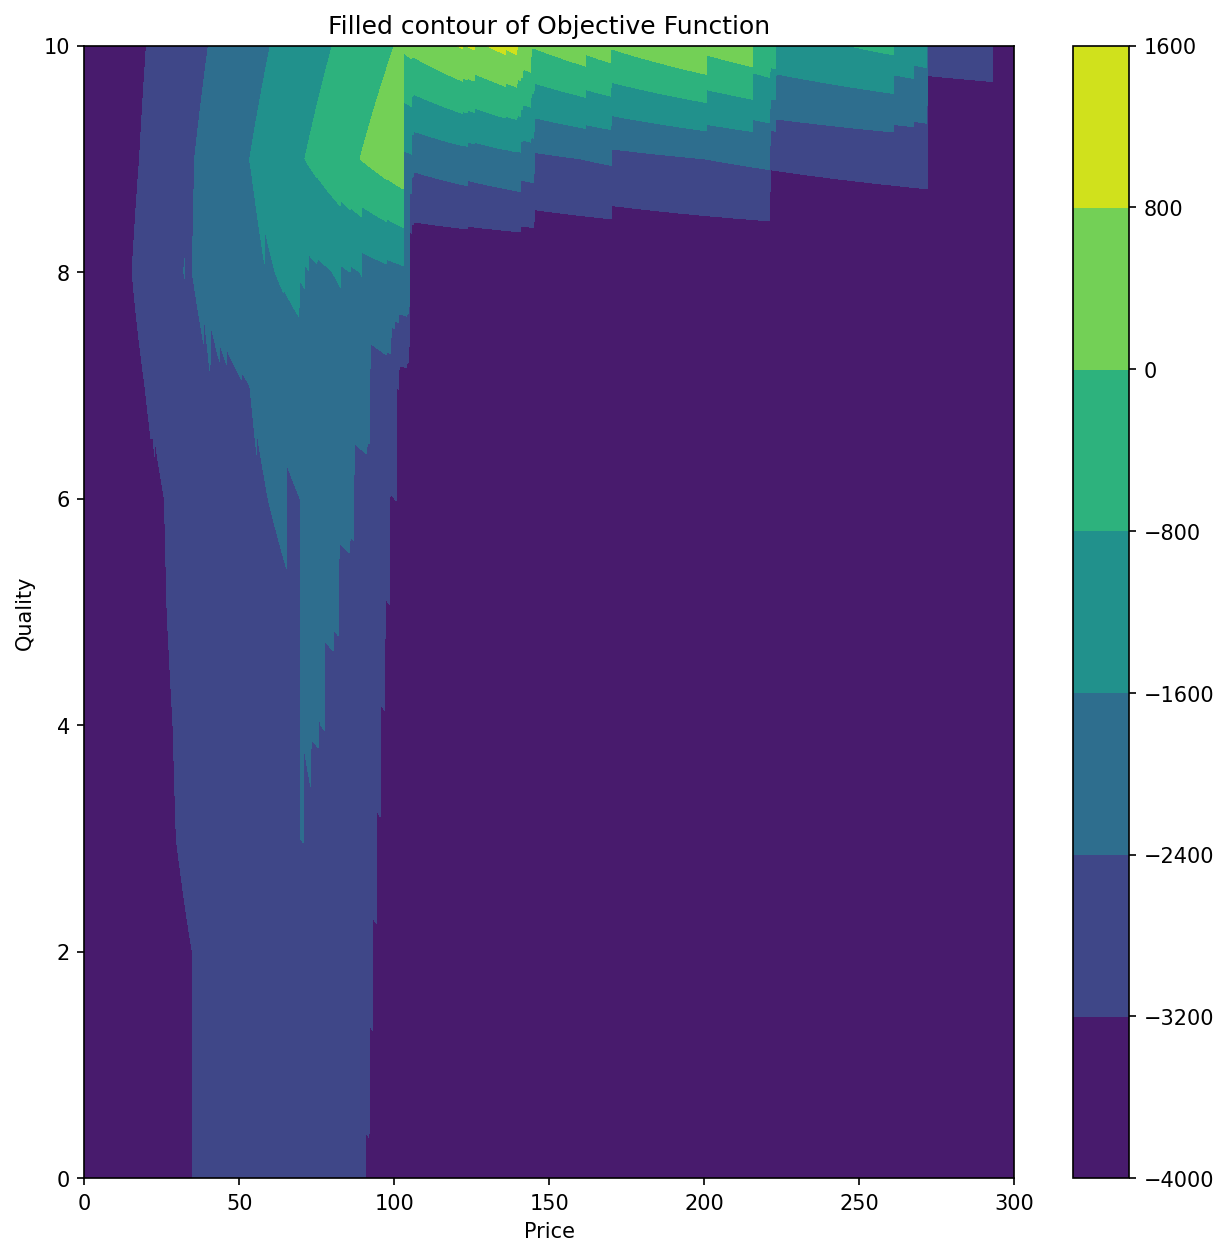

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10),dpi = 150)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled contour of Objective Function')
ax.set_xlabel('Price')
ax.set_ylabel('Quality')
plt.savefig("Filled contour.png", dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


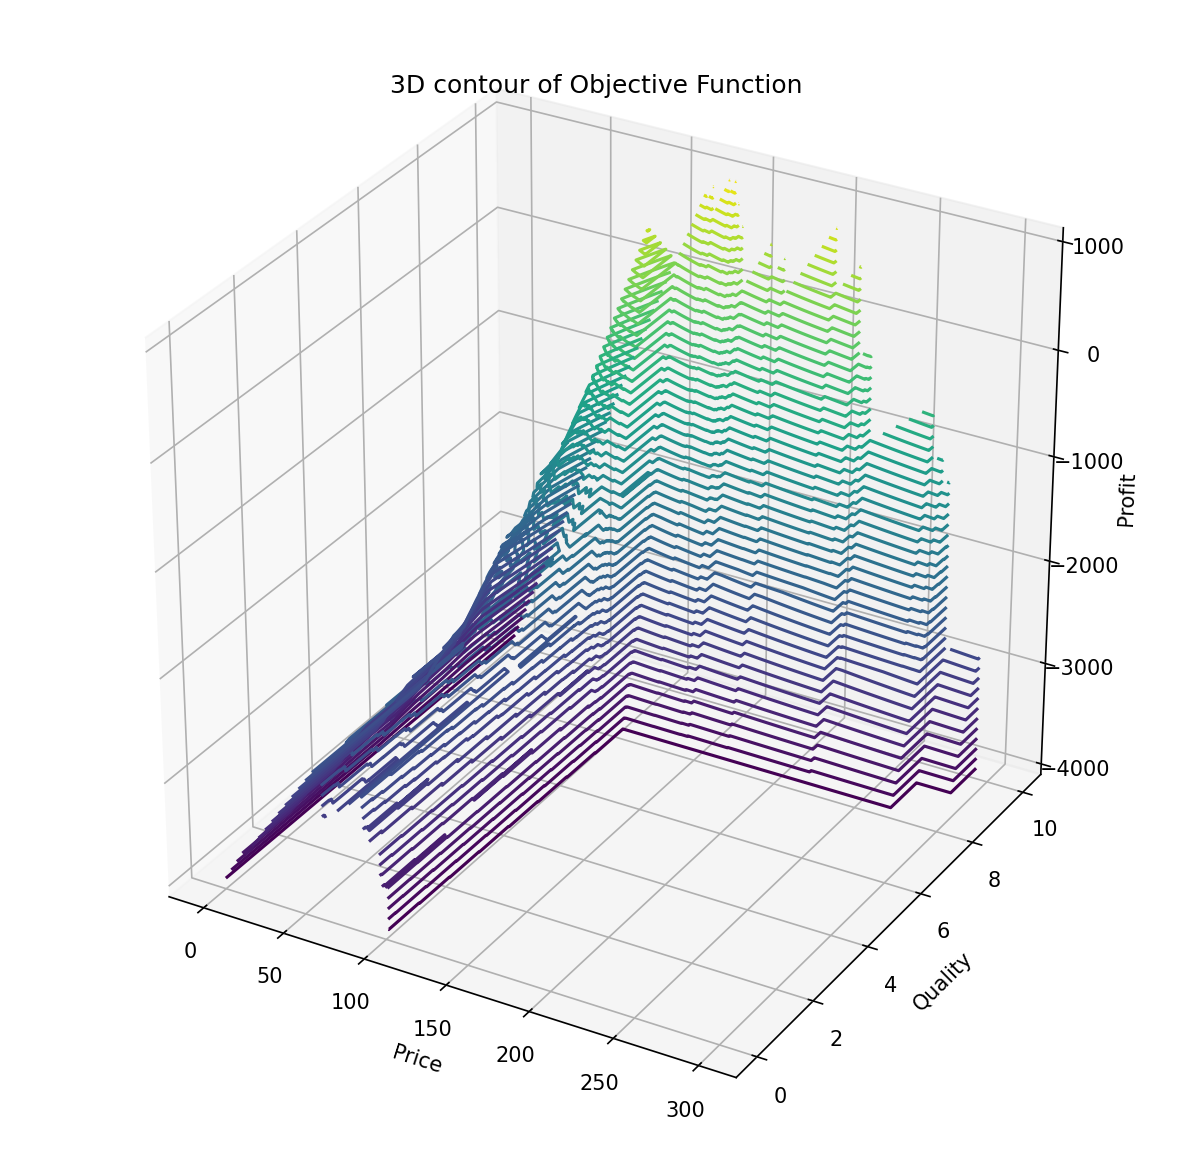

In [ ]:
fig = plt.figure(figsize=(10,10),dpi = 150)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('Price')
ax.set_ylabel('Quality')
ax.set_zlabel('Profit')
ax.set_title('3D contour of Objective Function')
plt.savefig("3D contour.png", dpi=150)
plt.show()

# For All Direction Method  



Operation Section (For 02 Method)

In [ ]:
#การกำหนด Hyperr Parameter สำหรับการ Optimize

Generation = 150         #จะมีการปรับกี่ Generation
Pricelr = 0.2             #lr คือ Hyper Parameter ในการปรับ Parameter
Qualitylr = 1 
Param = []
Num = 3                 #จำนวนของร้านที่ดีที่สุดที่จะเลือก
Momentum = 1.5   
mutate = True        #สำหรับ Method นี้จะให้มีการ Mutation หรือไม่

In [ ]:
#การกำหนด Agent ของเรา

Agents_List = []

xy_min = [0,0]
xy_max = [Budget_Range[1],10]       #[ราคาสูงสุด,คุณภาพสูงสุด]
uniform_initiate_param = numpy.random.uniform(low=xy_min, high=xy_max, size=(10,2)).tolist()

for a in uniform_initiate_param:
    Agents_List.append(AgentMaker(round(a[0]),round(a[1]),Capital,CostAtQuality))

#AgentMaker(price,quality,capital,CostAtQuality)

In [ ]:
MaxPt_History = []
MaxProductLeft_History = []
MaxQ_History = []
MaxPri_History = []
duplication_count = 0
MaxParam_History = []
start = time.time()
end0 = []
for gen in range(Generation):
    output = []
    Pt_List = []
    ParamHistory = []
    for shop in Agents_List:
        Shop_List_Inloop = list(InitiateFocusedShop(Shop_List,shop[1],shop[2],Capital,CostAtQuality))
        Simulate(Shop_List_Inloop,Customer_List)
        Pt_List.append(Shop_List_Inloop[5][-1])
        ParamHistory.append([x[-1] for x in Shop_List_Inloop])
    MaxPt_History.append(max(Pt_List))
    Survived_index = Select(Pt_List,Num)
    for index in Survived_index:
        output = output + Breed(Agents_List[index],Pricelr,Qualitylr,Capital,CostAtQuality,Momentum,price_limit,Ql_range,mutate)
    Agents_List = [list(x) for x in output]
    MaxParam_History.append(ParamHistory[Survived_index[0]])
    MaxProductLeft_History.append(ParamHistory[Survived_index[0]][0])
    MaxPri_History.append(ParamHistory[Survived_index[0]][1])
    MaxQ_History.append(ParamHistory[Survived_index[0]][2])
    if (gen+1)%5 == 0:
        print("Gen",gen+1,"has finished")
    if gen >= 2:
        if MaxPt_History[-1] == MaxPt_History[-2]:
            duplication_count += 1
        else:
            duplication_count = 0
        if duplication_count < 5:
            stabilized_generation = gen - duplication_count
    end0.append(time.time())
end = time.time()
print(f"Runtime of the program is {end - start}")
print(f"Runtime Before Stable is {end0[stabilized_generation]-start}")

Gen 5 has finished
Gen 10 has finished
Gen 15 has finished
Gen 20 has finished
Gen 25 has finished
Gen 30 has finished
Gen 35 has finished
Gen 40 has finished
Gen 45 has finished
Gen 50 has finished
Gen 55 has finished
Gen 60 has finished
Gen 65 has finished
Gen 70 has finished
Gen 75 has finished
Gen 80 has finished
Gen 85 has finished
Gen 90 has finished
Gen 95 has finished
Gen 100 has finished
Gen 105 has finished
Gen 110 has finished
Gen 115 has finished
Gen 120 has finished
Gen 125 has finished
Gen 130 has finished
Gen 135 has finished
Gen 140 has finished
Gen 145 has finished
Gen 150 has finished
Runtime of the program is 7.718801498413086
Runtime Before Stable is 2.28332257270813


 Result Section 
 
**(For 02 Method)**

In [ ]:
index_column = pd.DataFrame(np.array([i for i in range(len(MaxParam_History))]),columns = ["generation"])
print("Best Parameter of the latest generation of Method 02")
MaxParam_History_dataframe = pd.DataFrame(np.array(MaxParam_History),columns = ['remaining products','price','quality','revenue','capital','profit'])
MaxParam_History_dataframe = pd.concat([index_column,MaxParam_History_dataframe], axis = 1)
MaxParam_History_dataframe.tail()

Best Parameter of the latest generation of Method 02


,generation,remaining products,price,quality,revenue,capital,profit
145,145,0.0,103.0,9.0,4635.0,4000.0,635.0
146,146,0.0,103.0,9.0,4635.0,4000.0,635.0
147,147,0.0,103.0,9.0,4635.0,4000.0,635.0
148,148,0.0,103.0,9.0,4635.0,4000.0,635.0
149,149,0.0,103.0,9.0,4635.0,4000.0,635.0


Graph Of Method 02


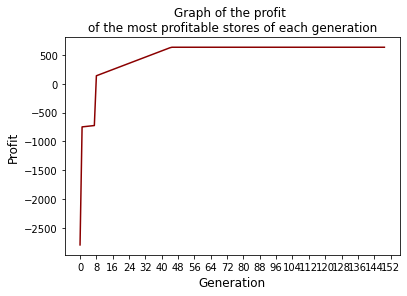

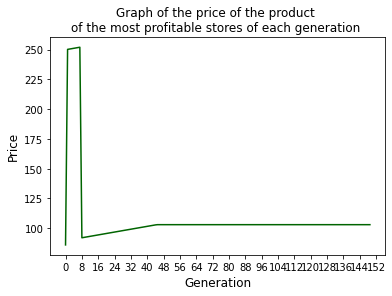

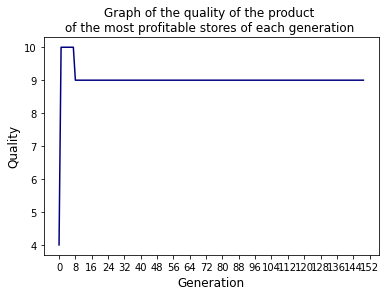

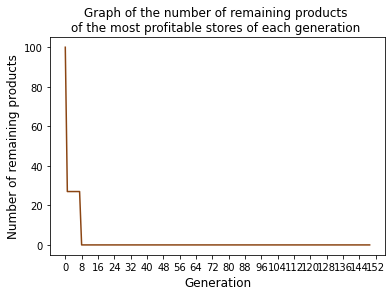

Generation that stabilize the whole optimization output = Generation  45


In [ ]:
print("Graph Of Method 02")
MultipleLocator = round(Generation/(20-1))
plt.plot(MaxPt_History,c="darkred")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Profit',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the profit \nof the most profitable stores of each generation")
plt.savefig("Profit_Graph_02Method.png", dpi=150)
plt.show()


plt.plot(MaxPri_History,c="darkgreen")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Price',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the price of the product \nof the most profitable stores of each generation ")
plt.savefig("Price_Graph_02Method.png", dpi=150)
plt.show()


plt.plot(MaxQ_History,c="navy")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Quality',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the quality of the product \nof the most profitable stores of each generation ")
plt.savefig("Quality_Graph_02Method.png", dpi=150)
plt.show()


plt.plot(MaxProductLeft_History,c="saddlebrown")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Number of remaining products',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the number of remaining products \nof the most profitable stores of each generation ")
plt.savefig("Remaining_Graph_02Method.png", dpi=150)
plt.show()


print("Generation that stabilize the whole optimization output = Generation ",stabilized_generation)

ส่วนของการนำผลที่ดีที่สุดมาจำลองใหม่เผื่อตรวจสอบผล

In [ ]:
Exper_Shop_List = InitiateFocusedShop(Shop_List,MaxParam_History[-1][1],MaxParam_History[-1][2],Capital,CostAtQuality)
before_pd = pd.DataFrame(np.array(Exper_Shop_List).T,columns = ['remaining products','price','quality','revenue','capital','profit'])
index_column_before = pd.DataFrame(np.array([i for i in range(len(np.array(Exper_Shop_List).T))]),columns = ["Shop No."])
before_pd = pd.concat([index_column_before,before_pd],axis=1)
before_pd

,Shop No.,remaining products,price,quality,revenue,capital,profit
0,0,800.0,125.0,0.0,0.0,4000.0,-4000.0
1,1,363.0,123.0,1.0,0.0,4000.0,-4000.0
2,2,210.0,120.0,2.0,0.0,4000.0,-4000.0
3,3,148.0,118.0,3.0,0.0,4000.0,-4000.0
4,4,114.0,115.0,4.0,0.0,4000.0,-4000.0
5,5,88.0,113.0,5.0,0.0,4000.0,-4000.0
6,6,72.0,110.0,6.0,0.0,4000.0,-4000.0
7,7,61.0,108.0,7.0,0.0,4000.0,-4000.0
8,8,52.0,105.0,8.0,0.0,4000.0,-4000.0
9,9,45.0,103.0,9.0,0.0,4000.0,-4000.0


In [ ]:
Simulate(Exper_Shop_List,Customer_List)

In [ ]:
after_pd = pd.DataFrame(np.array(Exper_Shop_List).T,columns = ['remaining products','price','quality','revenue','capital','profit'])
after_pd = pd.concat([index_column_before,after_pd],axis=1)
after_pd

,Shop No.,remaining products,price,quality,revenue,capital,profit
0,0,800.0,125.0,0.0,0.0,4000.0,-4000.0
1,1,363.0,123.0,1.0,0.0,4000.0,-4000.0
2,2,210.0,120.0,2.0,0.0,4000.0,-4000.0
3,3,148.0,118.0,3.0,0.0,4000.0,-4000.0
4,4,114.0,115.0,4.0,0.0,4000.0,-4000.0
5,5,88.0,113.0,5.0,0.0,4000.0,-4000.0
6,6,72.0,110.0,6.0,0.0,4000.0,-4000.0
7,7,61.0,108.0,7.0,0.0,4000.0,-4000.0
8,8,52.0,105.0,8.0,0.0,4000.0,-4000.0
9,9,23.0,103.0,9.0,2266.0,4000.0,-1734.0


การเซฟ Result (เป็น Excel) (กราฟเซฟไปก่อนแล้ว)

In [ ]:
last_sim_pd = pd.concat([before_pd, after_pd], axis = 1)
MaxParam_History_dataframe.to_excel("Optimization_History_02Method.xlsx")
last_sim_pd.to_excel("Best_Param_Simulation_02Method.xlsx")

# For Cells Method



Operation Section (For 03 Method)

In [ ]:
#การกำหนด Hyperr Parameter สำหรับการ Optimize

Generation = 150         #จะมีการปรับกี่ Generation
Pricelr = [10,9,8,7,6,5,4,3,2,1,0.5,0.1]             #lr จะปรับเมื่อเจอคำตอบซ้ำ ๆ 
Qualitylr = [1,1,1,1,1,1,1,1,1,1,1,1] 
param_lr = [Pricelr,Qualitylr]               #จำนวนของร้านที่ดีที่สุดที่จะเลือก
opt = Optimization([6,3],2,[[0,Budget_Range[1]],[0,10]],param_lr)
#__init__(self,distribution_num,parameter_num,param_limit,param_lr)

In [ ]:
init = opt.Initiate()
MaxParam_History = []
MaxPt_History = []
MaxProductLeft_History = []
MaxQ_History = []
MaxPri_History = []
duplication_count = 0
start = time.time()
end0 = []
lr_index = 0
stabilized_generation = Generation-1
for gen in range(Generation):
    Best_Param_History = []
    param = opt.Breed(init,lr_index) 
    init_len = len(init)
    init = []
    Best_of_cell_History = []
    for i in range(init_len):
        cell = param[i]
        Pt_List = []
        ParamHistory = []
        output = []
        for index,parameter in enumerate(cell):
            
            price = parameter[0]
            quality = round(parameter[1])
            Shop_List_Inloop = list(InitiateFocusedShop(Shop_List,price,quality,Capital,CostAtQuality))

            Simulate(Shop_List_Inloop,Customer_List)

            Pt_List.append(Shop_List_Inloop[5][-1])
            ParamHistory.append([x[-1] for x in Shop_List_Inloop])
                
        Survived_index = Select(Pt_List,1)[0]
        Best_of_cell = ParamHistory[Survived_index]
        Best_Price = Best_of_cell[1]
        Best_Quality = Best_of_cell[2]
        Best_of_cell_History.append(Best_of_cell)
        init.append([Best_Price,Best_Quality])

    Pt_of_each_cell = []
    for parameters in Best_of_cell_History:
    
        Pt_of_each_cell.append(parameters[-1])
    Best_index = Select(Pt_of_each_cell,1)[0]
    Best_of_gen_param = Best_of_cell_History[Best_index]
    MaxParam_History.append(Best_of_gen_param)
    MaxProductLeft_History.append(Best_of_gen_param[0])
    MaxPri_History.append(Best_of_gen_param[1])
    MaxQ_History.append(Best_of_gen_param[2])
    MaxPt_History.append(Best_of_gen_param[-1])

    if (gen+1)%5 == 0:
        print("Gen",gen+1,"has finished")
    if gen >= 2:
        if MaxPt_History[-1] == MaxPt_History[-2]:
            duplication_count += 1
        else :
            duplication_count = 0
            print("Duplication_Count Reset")

        if duplication_count % 5 == 0 and duplication_count != 0:
            stabilized_generation = gen - duplication_count
            if lr_index < len(Pricelr)-1: 
                lr_index += 1
                print(f"lr is = {Pricelr[lr_index]} duplication_count = {duplication_count}")
            else:
                lr_index = 0
                print(f"lr is = {Pricelr[lr_index]} duplication_count = {duplication_count}")
    end0.append(time.time())

end = time.time()
print(f"Runtime of the program is {end - start}")
print(f"Runtime Before Stable is {end0[stabilized_generation]-start}")

Gen 5 has finished
lr is = 9 duplication_count = 5
Duplication_Count Reset
Gen 10 has finished
lr is = 8 duplication_count = 5
Gen 15 has finished
lr is = 7 duplication_count = 10
Gen 20 has finished
lr is = 6 duplication_count = 15
Gen 25 has finished
lr is = 5 duplication_count = 20
Gen 30 has finished
lr is = 4 duplication_count = 25
Gen 35 has finished
lr is = 3 duplication_count = 30
Gen 40 has finished
lr is = 2 duplication_count = 35
Gen 45 has finished
lr is = 1 duplication_count = 40
Gen 50 has finished
lr is = 0.5 duplication_count = 45
Duplication_Count Reset
Gen 55 has finished
lr is = 0.1 duplication_count = 5
Gen 60 has finished
lr is = 10 duplication_count = 10
Gen 65 has finished
lr is = 9 duplication_count = 15
Gen 70 has finished
lr is = 8 duplication_count = 20
Gen 75 has finished
lr is = 7 duplication_count = 25
Gen 80 has finished
lr is = 6 duplication_count = 30
Gen 85 has finished
lr is = 5 duplication_count = 35
Gen 90 has finished
lr is = 4 duplication_count = 

Result Section (For 03 Method)

In [ ]:
index_column = pd.DataFrame(np.array([i for i in range(len(MaxParam_History))]),columns = ["generation"])
print("Best Parameter of the latest generation of Method 03")
MaxParam_History_dataframe = pd.DataFrame(np.array(MaxParam_History),columns = ['remaining products','price','quality','revenue','capital','profit'])
MaxParam_History_dataframe = pd.concat([index_column,MaxParam_History_dataframe], axis = 1)
MaxParam_History_dataframe.tail()

Best Parameter of the latest generation of Method 03


,generation,remaining products,price,quality,revenue,capital,profit
145,145,4.0,139.5,10.0,5022.0,4000.0,1022.0
146,146,4.0,139.5,10.0,5022.0,4000.0,1022.0
147,147,4.0,139.5,10.0,5022.0,4000.0,1022.0
148,148,4.0,139.5,10.0,5022.0,4000.0,1022.0
149,149,4.0,139.5,10.0,5022.0,4000.0,1022.0


Graph Of method 03


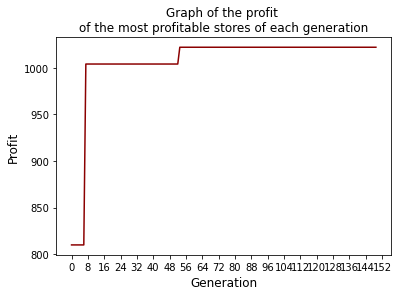

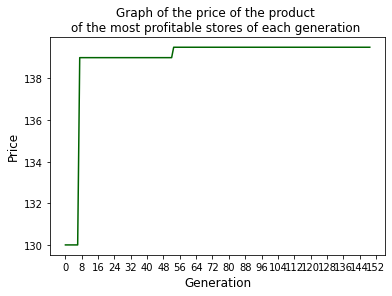

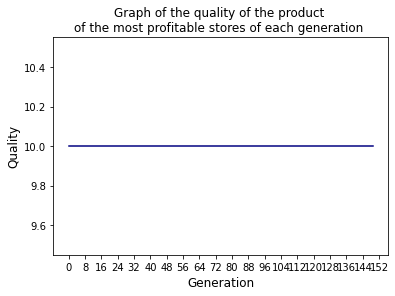

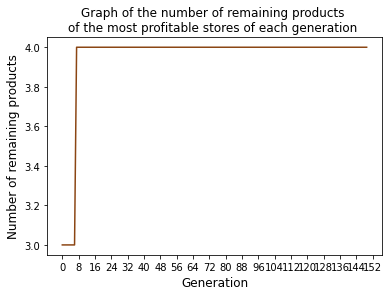

Generation that stabilize the whole optimization output = Generation  53


In [ ]:
print("Graph Of method 03")
MultipleLocator = round(Generation/(20-1))
plt.plot(MaxPt_History,c="darkred")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Profit',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the profit \nof the most profitable stores of each generation")
plt.savefig("Profit_Graph_03Method.png", dpi=150)
plt.show()


plt.plot(MaxPri_History,c="darkgreen")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Price',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the price of the product \nof the most profitable stores of each generation ")
plt.savefig("Price_Graph_03Method.png", dpi=150)
plt.show()


plt.plot(MaxQ_History,c="navy")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Quality',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the quality of the product \nof the most profitable stores of each generation ")
plt.savefig("Quality_Graph_03Method.png", dpi=150)
plt.show()


plt.plot(MaxProductLeft_History,c="saddlebrown")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Number of remaining products',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the number of remaining products \nof the most profitable stores of each generation ")
plt.savefig("Remaining_Graph_03Method.png", dpi=150)
plt.show()


print("Generation that stabilize the whole optimization output = Generation ",stabilized_generation)

ส่วนของการนำผลที่ดีที่สุดมาจำลองใหม่เผื่อตรวจสอบผล

**Method 03**

In [ ]:
Exper_Shop_List = InitiateFocusedShop(Shop_List,MaxParam_History[-1][1],MaxParam_History[-1][2],Capital,CostAtQuality)
before_pd = pd.DataFrame(np.array(Exper_Shop_List).T,columns = ['remaining products','price','quality','revenue','capital','profit'])
index_column_before = pd.DataFrame(np.array([i for i in range(len(np.array(Exper_Shop_List).T))]),columns = ["Shop No."])
before_pd = pd.concat([index_column_before,before_pd],axis=1)
before_pd

,Shop No.,remaining products,price,quality,revenue,capital,profit
0,0,800.0,125.0,0.0,0.0,4000.0,-4000.0
1,1,363.0,123.0,1.0,0.0,4000.0,-4000.0
2,2,210.0,120.0,2.0,0.0,4000.0,-4000.0
3,3,148.0,118.0,3.0,0.0,4000.0,-4000.0
4,4,114.0,115.0,4.0,0.0,4000.0,-4000.0
5,5,88.0,113.0,5.0,0.0,4000.0,-4000.0
6,6,72.0,110.0,6.0,0.0,4000.0,-4000.0
7,7,61.0,108.0,7.0,0.0,4000.0,-4000.0
8,8,52.0,105.0,8.0,0.0,4000.0,-4000.0
9,9,45.0,103.0,9.0,0.0,4000.0,-4000.0


In [ ]:
Simulate(Exper_Shop_List,Customer_List)

In [ ]:
after_pd = pd.DataFrame(np.array(Exper_Shop_List).T,columns = ['remaining products','price','quality','revenue','capital','profit'])
after_pd = pd.concat([index_column_before,after_pd],axis=1)
after_pd

,Shop No.,remaining products,price,quality,revenue,capital,profit
0,0,800.0,125.0,0.0,0.0,4000.0,-4000.0
1,1,363.0,123.0,1.0,0.0,4000.0,-4000.0
2,2,210.0,120.0,2.0,0.0,4000.0,-4000.0
3,3,148.0,118.0,3.0,0.0,4000.0,-4000.0
4,4,114.0,115.0,4.0,0.0,4000.0,-4000.0
5,5,88.0,113.0,5.0,0.0,4000.0,-4000.0
6,6,72.0,110.0,6.0,0.0,4000.0,-4000.0
7,7,61.0,108.0,7.0,0.0,4000.0,-4000.0
8,8,52.0,105.0,8.0,0.0,4000.0,-4000.0
9,9,14.0,103.0,9.0,3193.0,4000.0,-807.0


การเซฟ Result (เป็น Excel) (กราฟเซฟไปก่อนแล้ว)

In [ ]:
last_sim_pd = pd.concat([before_pd, after_pd], axis = 1)
MaxParam_History_dataframe.to_excel("Optimization_History_03Method.xlsx")
last_sim_pd.to_excel("Best_Param_Simulation_03Method.xlsx")

# For GA Method

Operation Section (For GA Method)

In [ ]:
sol_per_pop = 8         #จำนวนประชากรใหม่ในแต่ละ Generation
num_parents_mating = 4  #จะเลือก Parent duj8o
num_weights = 2         #ต้นทุนกับคุณภาพรวมเป็น 2 (ไม่ต้องปรับ)
num_generations = 150   #ปรับกี่ Generation

In [ ]:
# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
#Creating the initial population.
xy_min = [0,0]
xy_max = [Budget_Range[1],9]
new_population = numpy.random.uniform(low=xy_min, high=xy_max, size=pop_size)
print(new_population)
MaxPt_History = []
duplication_count = 0
start = time.time()
end0 = []
for generation in range(num_generations):
    # Measing the fitness of each chromosome in the population.
    Pt_List = []
    for index,parameter in enumerate(new_population):
            
            price = round(parameter[0],1)
            quality = round(parameter[1])
            Shop_List_Inloop = list(InitiateFocusedShop(Shop_List,price,quality,Capital,CostAtQuality))

            Simulate(Shop_List_Inloop,Customer_List)

            Pt_List.append(Shop_List_Inloop[5][-1])
    fitness = numpy.array(Pt_List)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                      num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                       offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
    Pt_List = []
    for index,parameter in enumerate(new_population):
            
            price = round(parameter[0],1)
            quality = round(parameter[1])
            if round(quality) > 10 or round(quality) < 0:
                Pt_List.append(-99999)
                continue
            Shop_List_Inloop = list(InitiateFocusedShop(Shop_List,price,quality,Capital,CostAtQuality))

            Simulate(Shop_List_Inloop,Customer_List)

            Pt_List.append(Shop_List_Inloop[5][-1])

    # The best result in the current iteration.
    MaxPt_History.append(numpy.max(numpy.array(Pt_List)))

    if (generation+1)%5 == 0:
        print("Gen",generation+1,"has finished")
        print("Best result : ", numpy.max(numpy.array(Pt_List)))
    if generation >= 2:
        if MaxPt_History[-1] == MaxPt_History[-2]:
            duplication_count += 1
        else:
            duplication_count = 0
        if duplication_count < 5:
            stabilized_generation = generation - duplication_count
    end0.append(time.time())


# Getting the best solution after iterating finishing all generations.
#At first, the fitness is calculated for each solution in the final generation.

end = time.time()

Pt_List = []
for index,parameter in enumerate(new_population.tolist()):
            price = round(parameter[0],1)
            quality = round(parameter[1])
            Shop_List_Inloop = list(InitiateFocusedShop(Shop_List,price,quality,Capital,CostAtQuality))

            Simulate(Shop_List_Inloop,Customer_List)

            Pt_List.append(Shop_List_Inloop[5][-1])

fitness = np.array(Pt_List)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = numpy.where(fitness == numpy.max(fitness))[0]
print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])
print(f"Runtime of the program is {end - start}")
print(f"Runtime Before Stable is {end0[stabilized_generation]-start}")

[[1.47050072e+02 7.90763035e+00]
 [1.95536519e+02 3.75096203e+00]
 [1.53422724e+01 7.40796960e+00]
 [6.61785375e+01 2.08087558e+00]
 [9.04195639e+01 1.73927689e+00]
 [8.21698548e+01 8.12037621e+00]
 [5.22992478e+01 7.75815610e-02]
 [3.98157241e+01 4.54137376e+00]]
Gen 5 has finished
Best result :  -300.99999999999955
Gen 10 has finished
Best result :  -300.99999999999955
Gen 15 has finished
Best result :  -206.50000000000048
Gen 20 has finished
Best result :  -125.50000000000034
Gen 25 has finished
Best result :  -80.50000000000034
Gen 30 has finished
Best result :  -26.50000000000051
Gen 35 has finished
Best result :  14.000000000000512
Gen 40 has finished
Best result :  108.49999999999949
Gen 45 has finished
Best result :  166.99999999999972
Gen 50 has finished
Best result :  230.0
Gen 55 has finished
Best result :  293.0000000000003
Gen 60 has finished
Best result :  329.0000000000005
Gen 65 has finished
Best result :  378.4999999999995
Gen 70 has finished
Best result :  410.0
Gen 7

Result testing

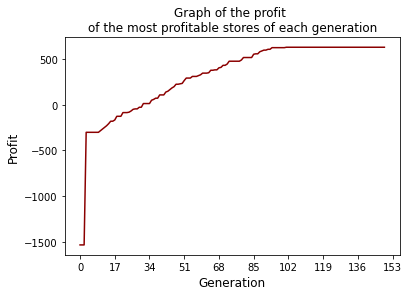

Generation that stabilize the whole optimization output = Generation 101


In [ ]:
MultipleLocator = round(num_generations/(10-1))
plt.plot(MaxPt_History,c="darkred")
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(MultipleLocator))
plt.ylabel('Profit',size=12) 
plt.xlabel('Generation',size=12)
plt.title("Graph of the profit \nof the most profitable stores of each generation")
plt.savefig("Profit_Graph_GAMethod.png", dpi=150)
plt.show()
print("Generation that stabilize the whole optimization output = Generation",stabilized_generation)

In [ ]:
best_param = new_population[best_match_idx, :][0]
price = round(best_param[0],1)
quality = round(best_param[1])

In [ ]:
Exper_Shop_List = InitiateFocusedShop(Shop_List,price,quality,Capital,CostAtQuality)
before_pd = pd.DataFrame(np.array(Exper_Shop_List).T,columns = ['remaining products','price','quality','revenue','capital','profit'])
index_column_before = pd.DataFrame(np.array([i for i in range(len(np.array(Exper_Shop_List).T))]),columns = ["Shop No."])
before_pd = pd.concat([index_column_before,before_pd],axis=1)
before_pd

,Shop No.,remaining products,price,quality,revenue,capital,profit
0,0,800.0,125.0,0.0,0.0,4000.0,-4000.0
1,1,363.0,123.0,1.0,0.0,4000.0,-4000.0
2,2,210.0,120.0,2.0,0.0,4000.0,-4000.0
3,3,148.0,118.0,3.0,0.0,4000.0,-4000.0
4,4,114.0,115.0,4.0,0.0,4000.0,-4000.0
5,5,88.0,113.0,5.0,0.0,4000.0,-4000.0
6,6,72.0,110.0,6.0,0.0,4000.0,-4000.0
7,7,61.0,108.0,7.0,0.0,4000.0,-4000.0
8,8,52.0,105.0,8.0,0.0,4000.0,-4000.0
9,9,45.0,103.0,9.0,0.0,4000.0,-4000.0


In [ ]:
Simulate(Exper_Shop_List,Customer_List)

In [ ]:
after_pd = pd.DataFrame(np.array(Exper_Shop_List).T,columns = ['remaining products','price','quality','revenue','capital','profit'])
after_pd = pd.concat([index_column_before,after_pd],axis=1)
after_pd

,Shop No.,remaining products,price,quality,revenue,capital,profit
0,0,800.0,125.0,0.0,0.0,4000.0,-4000.0
1,1,363.0,123.0,1.0,0.0,4000.0,-4000.0
2,2,210.0,120.0,2.0,0.0,4000.0,-4000.0
3,3,148.0,118.0,3.0,0.0,4000.0,-4000.0
4,4,114.0,115.0,4.0,0.0,4000.0,-4000.0
5,5,88.0,113.0,5.0,0.0,4000.0,-4000.0
6,6,72.0,110.0,6.0,0.0,4000.0,-4000.0
7,7,61.0,108.0,7.0,0.0,4000.0,-4000.0
8,8,52.0,105.0,8.0,0.0,4000.0,-4000.0
9,9,23.0,103.0,9.0,2266.0,4000.0,-1734.0


In [ ]:
last_sim_pd = pd.concat([before_pd, after_pd], axis = 1)
MaxParam_History_dataframe.to_excel("Optimization_History_GAMethod.xlsx")
last_sim_pd.to_excel("Best_Param_Simulation_GAMethod.xlsx")